In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.integrate import odeint

from numba import njit

@njit
def g(y, t, beta, gamma, mu):
    S, I, R = y
    N = S + I + R
    return -beta * S * I / N + mu * R, \
            beta * S * I / N - gamma * I, \
            gamma * I - mu * R

# Solve system of ODEs, return solution time-series
def curve(t, y0, beta, gamma, mu):
    return odeint(g, y0, t, args = (beta, gamma, mu))[:, 1]

# Load model infection curve from datafile
def load_curve(p, n):
    filename = "output/p%d/countdata_%03d.dat" % (p, n)
    df = pd.read_csv(filename)
    df = df.rename(columns = str.strip)
    return df[["Time", "Infected"]].to_numpy()

# Load selected model infection curves from datafiles
def load_curves(p, trials, t_cut = 100):
    data = list()
    tmax = 0
    for n in trials:
        c = load_curve(p, n)

        # Discard extinctions
        if c[:t_cut, 1].max() < 1e3:
            continue
        data.append(c[:t_cut, 1])

    return data

# Fit ODE parameters to model infection curves.
# The parameters beta, gamma, mu are shared across all curves,
# while the initial condition I_0 is allowed to vary.
def fit(p, t_cut = 100, trials = range(1, 101)):
    ys = load_curves(p, t_cut = t_cut, trials = trials)
    tmaxs = [len(y) for y in ys]

    def f(t, beta, gamma, mu, *I0s):
        sols = []
        for I0, tmax in zip(I0s, tmaxs):
            t_ = np.arange(0, tmax + 1, 1e-2)
            y0 = (1e4 - I0, I0, 0.0)
            sol = curve(t_, y0, beta, gamma, mu)
            sol = sol[:100 * tmax:100]
            sols.append(sol)

        return np.hstack(sols)

    p0 = np.hstack([
        [3.5e-1, 1 / 8, 0],
        np.ones(len(ys))
    ])

    bounds = (
        np.hstack([
            [0, 0, 0],
            1e-3 * np.ones(len(ys))
        ]),
        np.hstack([
            [2, 1, 1],
            1e3 * np.ones(len(ys))
        ])
    )

    # Concatenate all curves
    y = np.hstack(ys)
    t = np.arange(0, y.shape[0], 1.0)

    popt, pcov, infodict, mesg, ier = curve_fit(f, t, y, p0 = p0, full_output = True, bounds = bounds)
    print(p, repr(popt))

    return popt

# Show all curves along with ODE curves (with specified parameters)
def fit_show(p, popt, t_cut = 100, fig = 1, trials = range(1, 101)):
    ys = load_curves(p, t_cut = t_cut, trials = trials)
    tmaxs = [len(y) for y in ys]

    # Extract parameters
    beta, gamma, mu = popt[:3]
    I0s = popt[3:]

    # Calculate grid size: maximium of 5 columns
    cols = int(np.ceil(np.sqrt(len(ys))))
    cols = min(cols, 5)
    rows = int(np.ceil(len(ys) / cols))

    plt.figure(fig, figsize = (2 * cols, 2 * rows))

    for i in range(len(ys)):
        t_ = np.arange(0, tmaxs[i], 1.0)
        y_ = ys[i]
        y0 = (1e4 - I0s[i], I0s[i], 0.0)

        ax = plt.subplot2grid((rows, cols), (i % rows, i // rows))
        ax.plot(t_, y_, label = "Simulated")
        ax.plot(t_, curve(t_, y0, beta, gamma, mu), label = "Fitted")

    plt.suptitle("p = %f" % (p / 1000))

In [ ]:
# Time cutoff for model infection curves
cutoffs = {
    3: 80,
    4: 80,
    5: 80,
    6: 80,
    8: 80
}

In [ ]:
coeffs = dict()

for p, t_cut in cutoffs.items():
    coeffs[p] = fit(p, t_cut = t_cut, trials = range(1, 201))

3 array([3.22733099e-01, 1.75565204e-01, 1.76128588e-04, 3.31643655e+01,
       5.74846771e+01, 4.11760998e+00, 5.51248173e-01, 9.20040164e-01,
       2.05281500e+01, 1.17440199e+02, 1.66965497e+01, 1.93694760e+01,
       2.10696735e+01, 7.14430362e+01, 4.72421249e-01, 3.72052173e+01,
       8.32304994e+01, 7.03564655e+01, 2.54592477e+01, 5.13299602e+01,
       1.63076358e+01, 1.42363378e+02, 1.03100304e+02, 2.11868089e+01,
       3.52406898e+01, 7.69493500e+01, 2.88844913e+01, 6.48747610e+01,
       2.68239979e+01, 9.60897215e+01, 4.80040493e+00, 3.92391532e+00,
       5.07341145e+01, 1.02921928e+02, 1.59233817e+02, 8.54315802e+01,
       1.06145422e+01, 2.48009389e+00, 2.38625177e+01, 8.38203477e+01,
       1.44303750e+01, 8.24596796e+01, 1.59178826e+02, 1.87069741e+01,
       5.41447395e+01, 9.87064007e+00, 1.26671314e+02, 1.45954128e+02,
       1.20702298e+02, 4.91607801e+00, 1.62944551e+00, 1.82174248e+02,
       7.91916112e+01, 9.36516752e+01, 2.63783841e+00, 2.68482685e+00,
    

In [ ]:
beta = {p: coeff[0] for p, coeff in coeffs.items()}
beta

{3: 0.3227330992122408,
 4: 0.3474105478831132,
 5: 0.46116829053276936,
 6: 0.5750482602522292,
 8: 0.753366398496945}

In [ ]:
gamma = {p: coeff[1] for p, coeff in coeffs.items()}
gamma

{3: 0.1755652038462119,
 4: 0.14441228374817916,
 5: 0.13865651687592587,
 6: 0.13356349278758914,
 8: 0.1263290352509256}

In [ ]:
mu = {p: coeff[2] for p, coeff in coeffs.items()}
mu

{3: 0.00017612858770687674,
 4: 5.018990780781256e-35,
 5: 1.0858648222885675e-28,
 6: 9.761307863750985e-37,
 8: 9.145529480685097e-23}

In [ ]:
# Approximation of R_0
{i: beta[i] / gamma[i] for i in coeffs}

{3: 1.8382520689859596,
 4: 2.4056855751198767,
 5: 3.3259763112716656,
 6: 4.3054299363580535,
 8: 5.96352530517267}

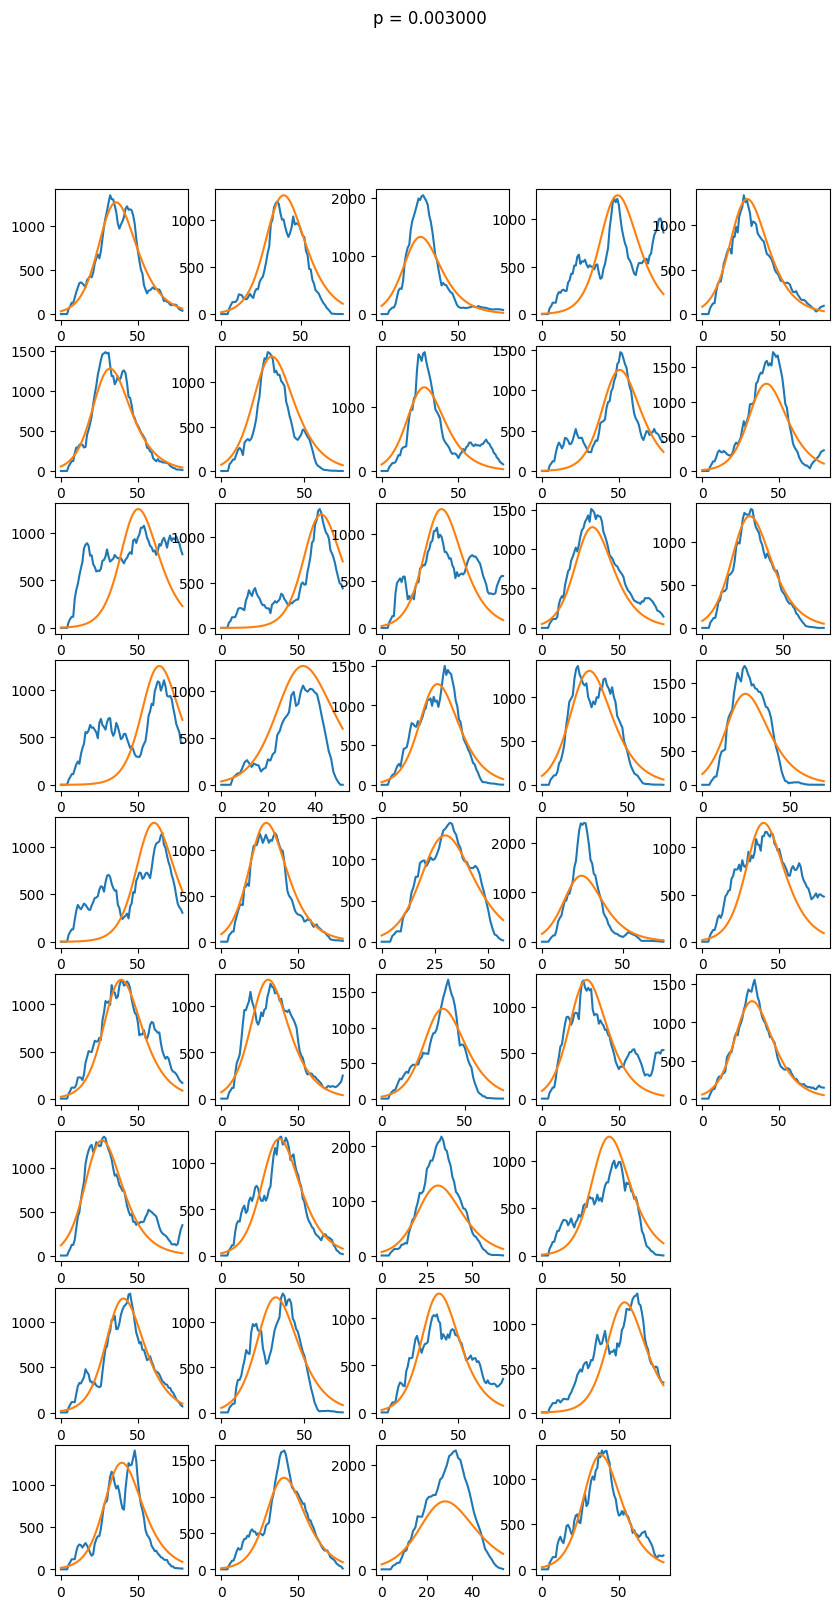

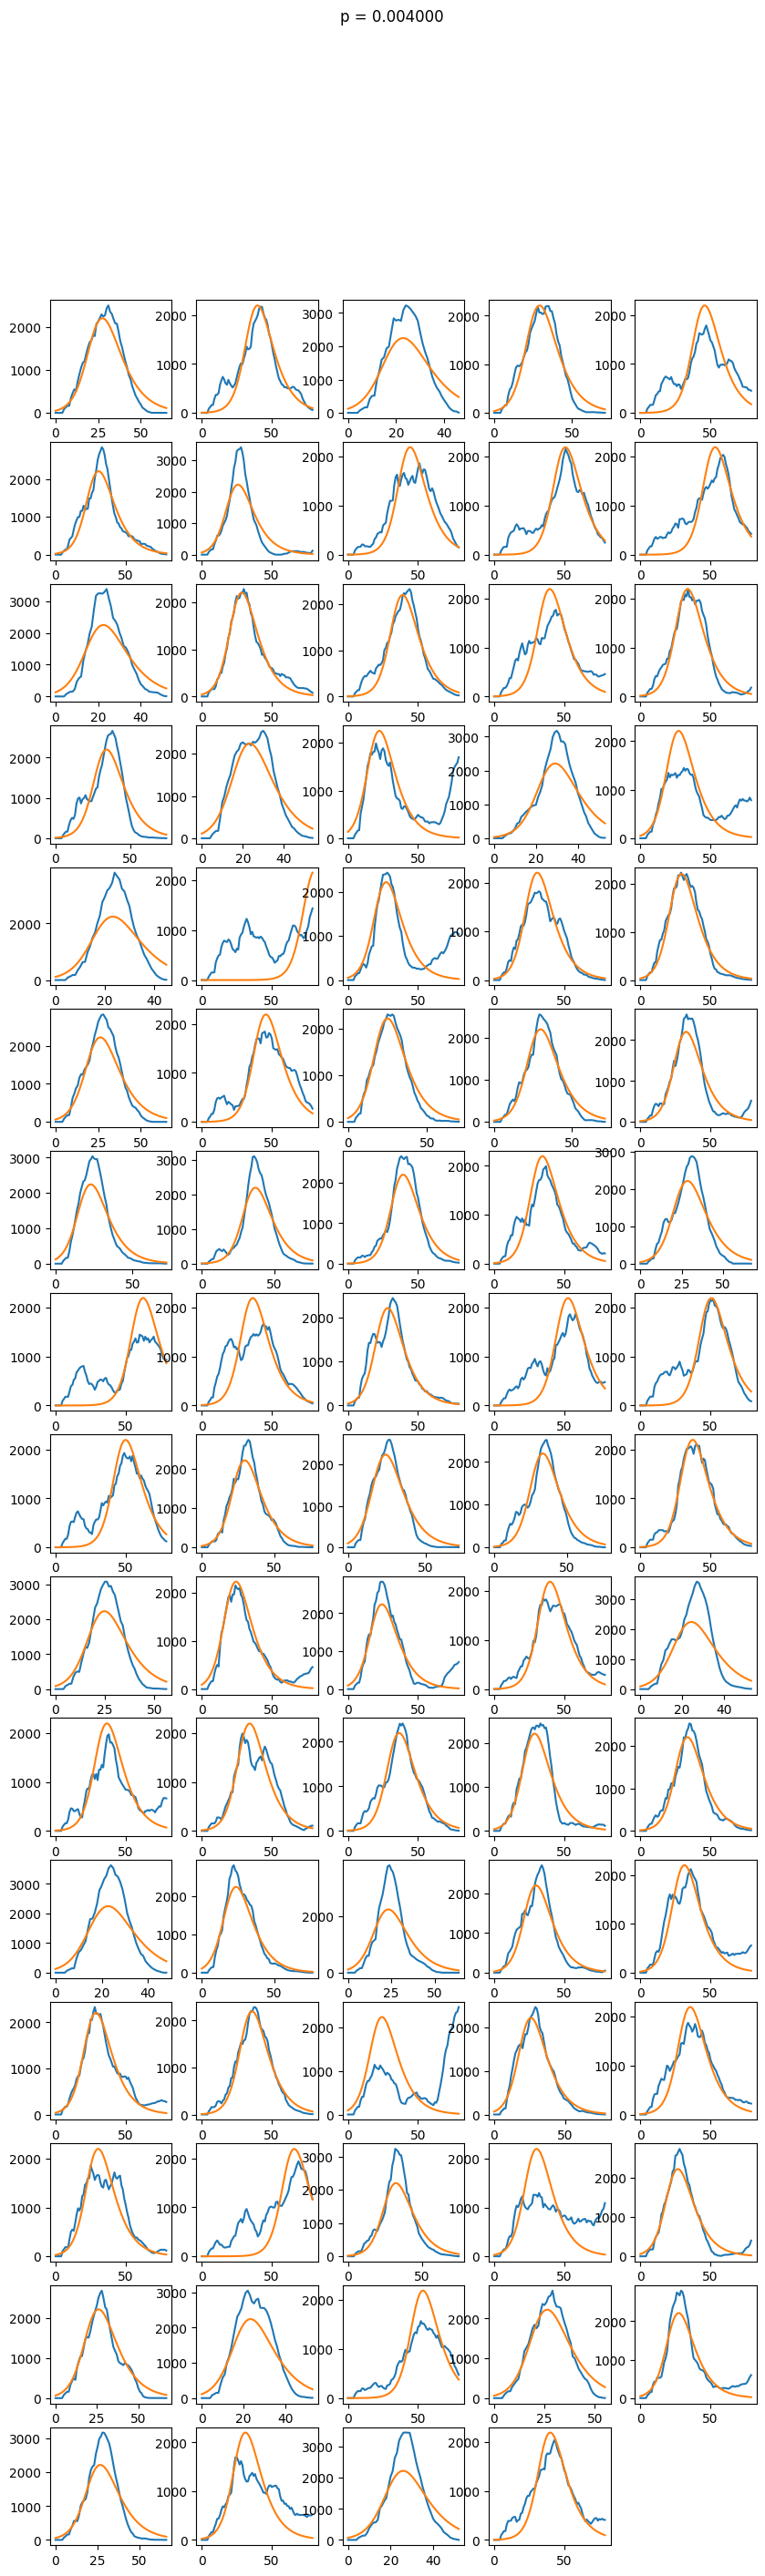

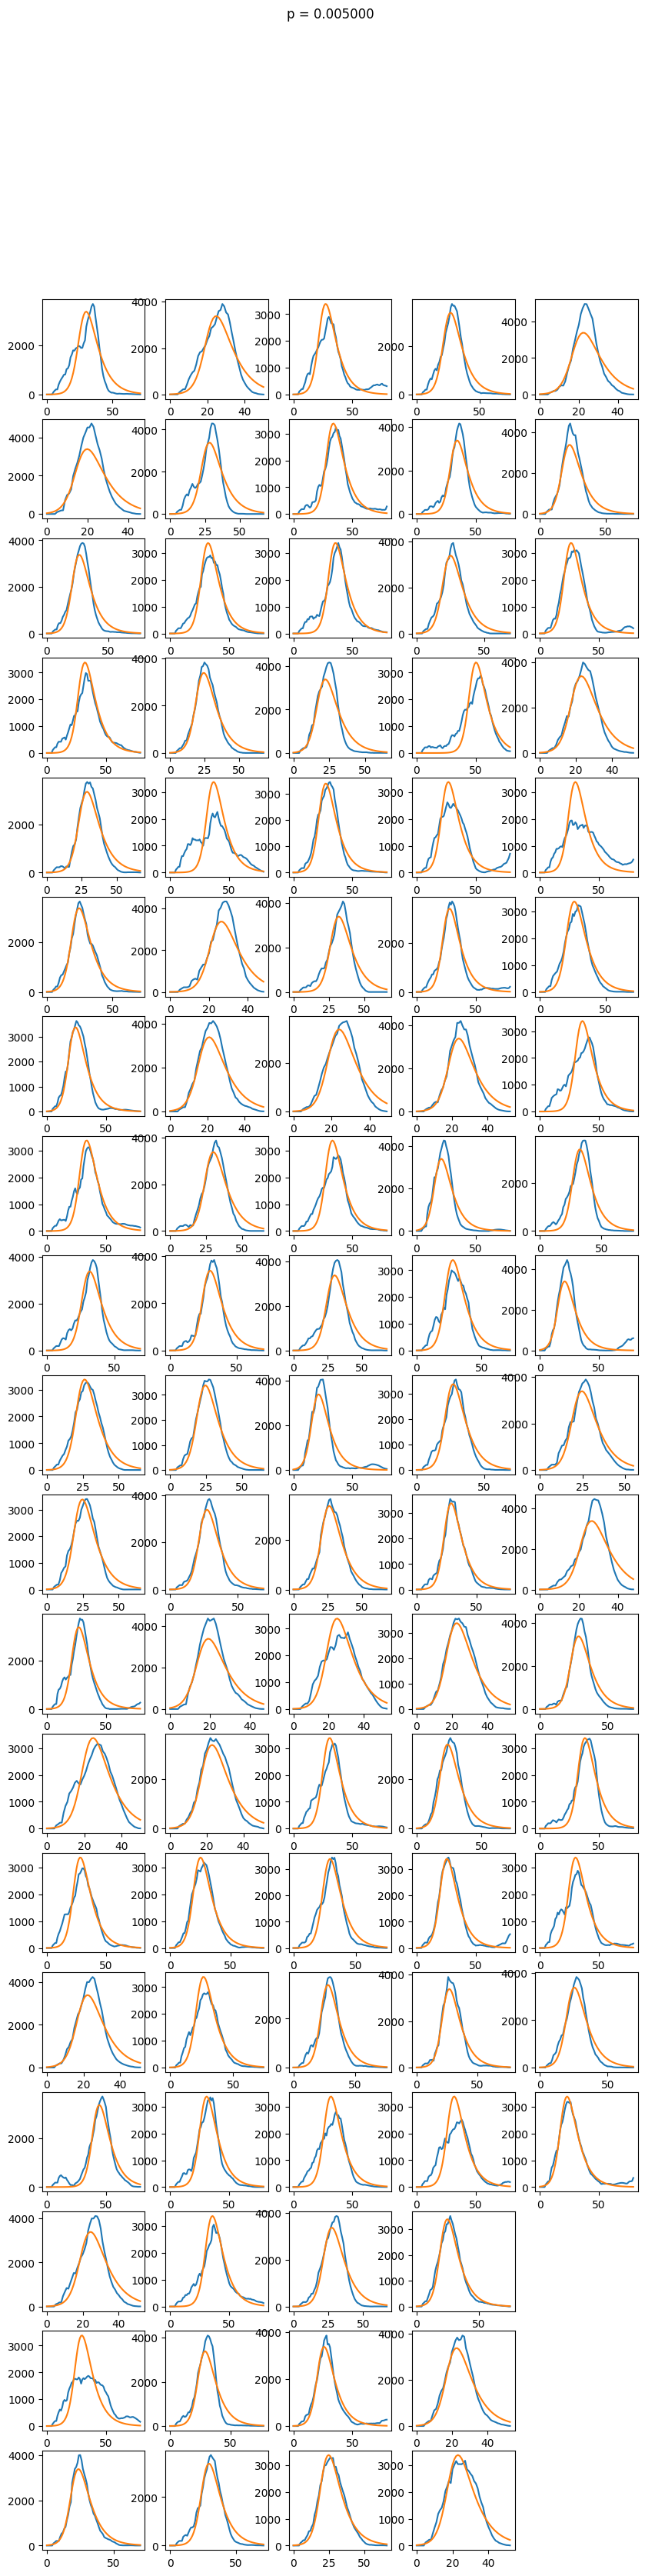

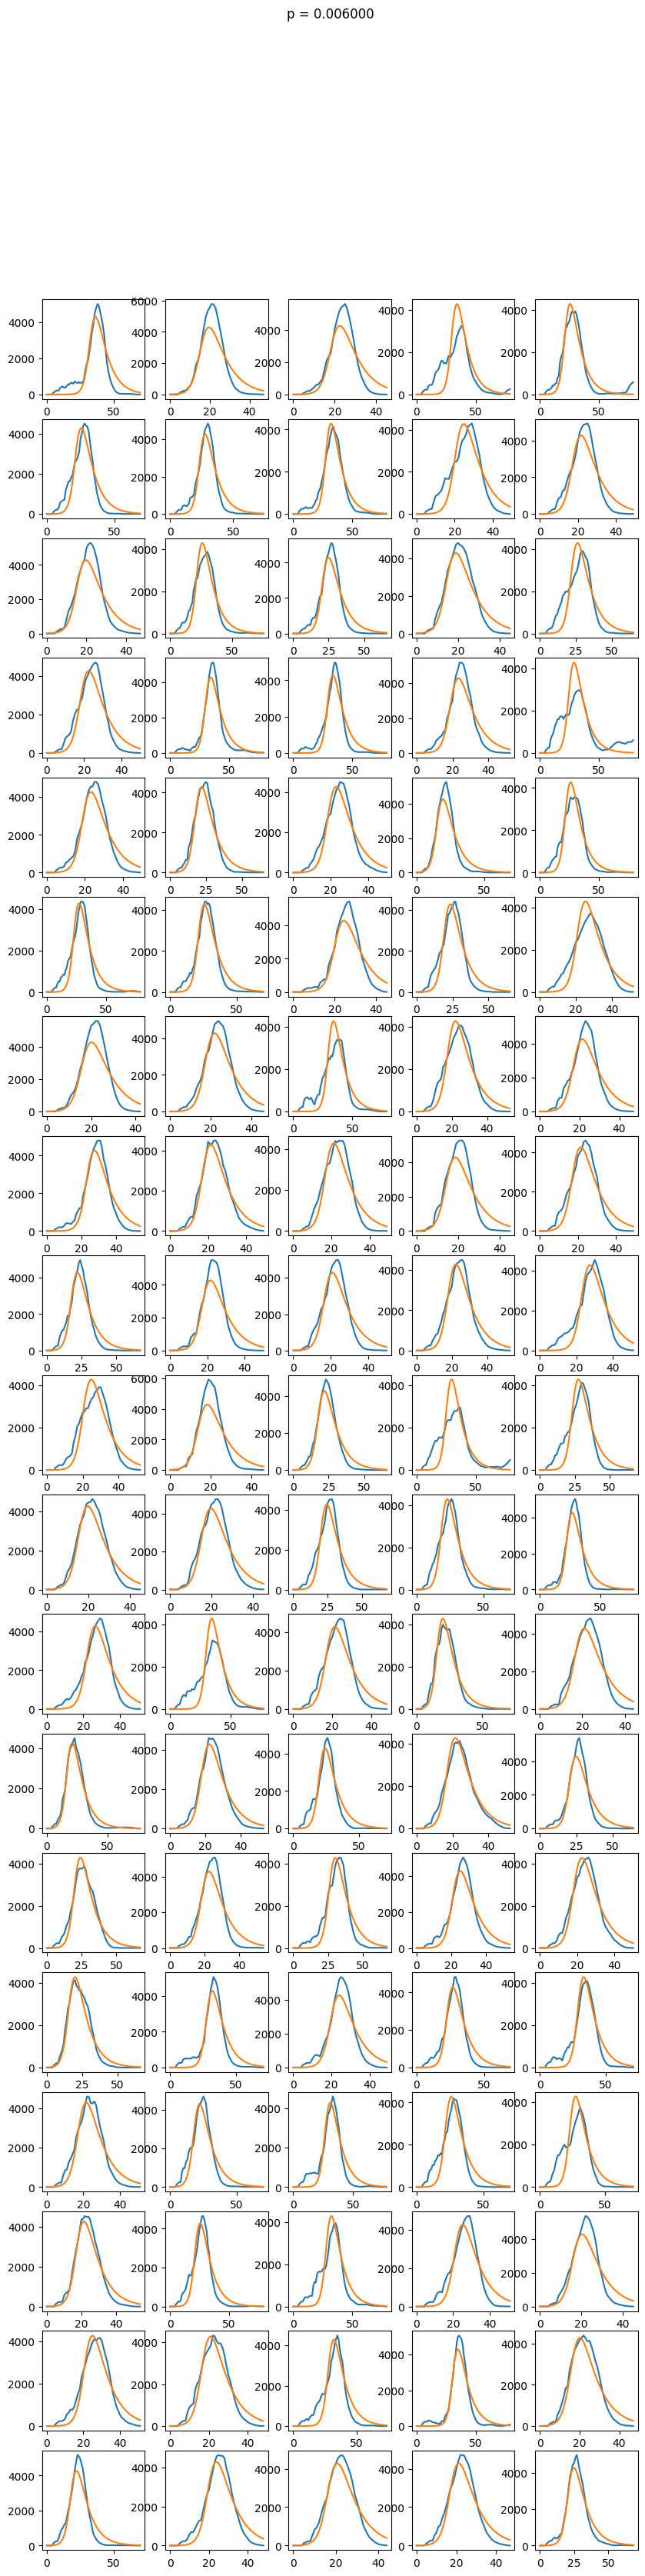

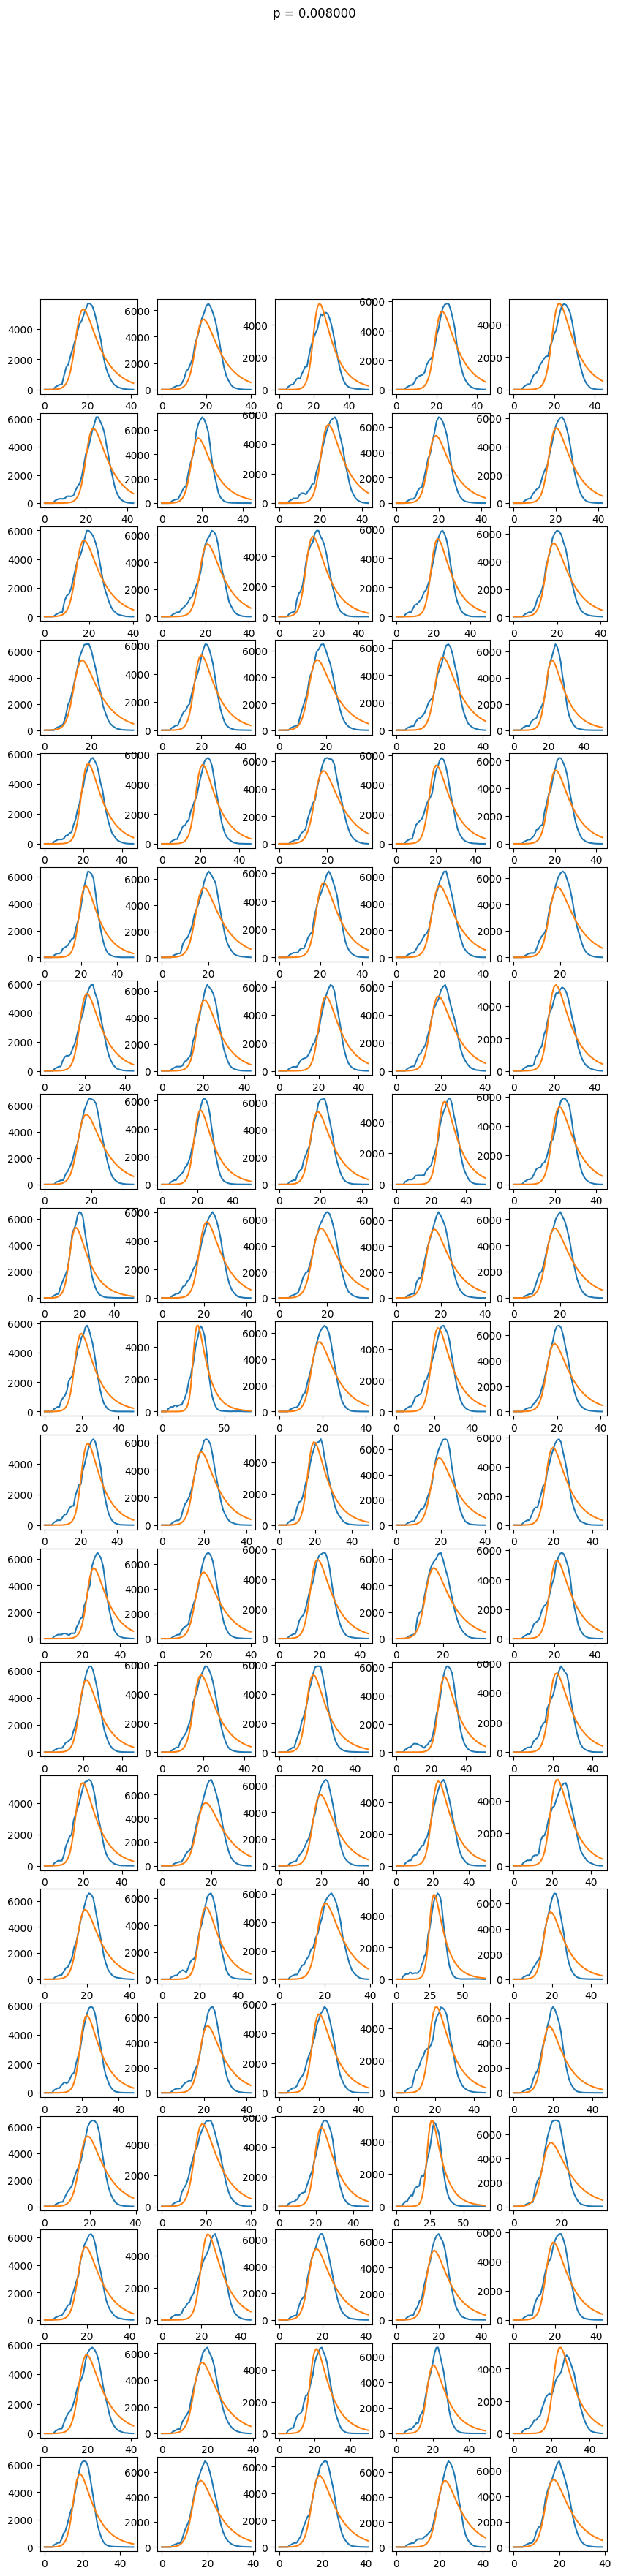

In [ ]:
fig = 1
for p, t_cut in cutoffs.items():
    fit_show(p, coeffs[p], t_cut = t_cut, fig = fig, trials = range(1, 101))
    fig += 1
plt.show()